# Use LGBM for prediction


TODO:
- Add new features
- Create competition prediction
- Clean code

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df_train = pd.read_csv("data/train-metadata.csv")
df_test = pd.read_csv("data/test-metadata.csv")

df_train.info()

C:\Users\thier\AppData\Local\Temp\ipykernel_15468\488414996.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("data/train-metadata.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [2]:
# Based on: https://www.kaggle.com/code/metric/isic-pauc-abovetpr
from sklearn.metrics import roc_auc_score
import numpy as np

def score(solution: np.ndarray, submission: np.ndarray, min_tpr: float=0.80) -> float:
    """_summary_

    Args:
        solution (np.ndarray): _description_
        submission (np.ndarray): _description_
        min_tpr (float, optional): _description_. Defaults to 0.80.

    Returns:
        float: _description_
    """
    v_gt = abs(solution-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return (partial_auc)

def pauc_80(preds, data):
    score_value = score(data.get_label(), preds, min_tpr=0.8)   
    return 'pauc_80', score_value, True

In [3]:
categorical_cols = [
    'tbp_lv_location_simple',
    'tbp_lv_location',
    'tbp_tile_type',
    'attribution',
    'anatom_site_general',
    'sex',
    'copyright_license'
]

feature_cols = [
    'age_approx',
    'sex',
    'anatom_site_general',
    'clin_size_long_diam_mm',
    'tbp_tile_type',
    'tbp_lv_A',
    'tbp_lv_Aext',
    'tbp_lv_B',
    'tbp_lv_Bext',
    'tbp_lv_C',
    'tbp_lv_Cext',
    'tbp_lv_H',
    'tbp_lv_Hext',
    'tbp_lv_L',
    'tbp_lv_Lext',
    'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio',
    'tbp_lv_color_std_mean',
    'tbp_lv_deltaA',
    'tbp_lv_deltaB',
    'tbp_lv_deltaL',
    'tbp_lv_deltaLBnorm',
    'tbp_lv_eccentricity',
    'tbp_lv_location',
    'tbp_lv_location_simple',
    'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence',
    'tbp_lv_norm_border',
    'tbp_lv_norm_color',
    'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max',
    'tbp_lv_stdL',
    'tbp_lv_stdLExt',
    'tbp_lv_symm_2axis',
    'tbp_lv_symm_2axis_angle',
    'tbp_lv_x',
    'tbp_lv_y',
    'tbp_lv_z',
    'attribution',
    'copyright_license',
]

In [6]:
import random
import sklearn
import sklearn.preprocessing
from lightgbm.callback import log_evaluation, early_stopping

X = df_train[feature_cols].copy()  # Making a copy to avoid modifying the original dataframe
y = df_train["target"]
groups = df_train["patient_id"]

category_encoder = sklearn.preprocessing.OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(X[categorical_cols])
for c, cat_col in enumerate(categorical_cols):
    X[cat_col] = X_cat[:, c]
    
# Separating features and target
X_test = df_test[feature_cols]

# Encoding categorical features with LabelEncoder
X_cat_test = category_encoder.transform(X_test[categorical_cols])
for c, cat_col in enumerate(categorical_cols):
    X_test[cat_col] = X_cat_test[:, c]

C:\Users\thier\AppData\Local\Temp\ipykernel_15468\1668982367.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[cat_col] = X_cat_test[:, c]



 3000 0.001 0.21 1.47 0.75 0.05 0.7 33 70 



c:\Users\thier\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:738: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Training until validation scores don't improve for 77 rounds
[10]	cv_agg's valid binary_logloss: 0.00759167 + 0.00011074	cv_agg's valid pauc_80: 0.132983 + 0.00661213
[20]	cv_agg's valid binary_logloss: 0.00742542 + 0.000108313	cv_agg's valid pauc_80: 0.137433 + 0.00503549
[30]	cv_agg's valid binary_logloss: 0.00729346 + 0.000111063	cv_agg's valid pauc_80: 0.138319 + 0.0052692
[40]	cv_agg's valid binary_logloss: 0.00718445 + 0.000114293	cv_agg's valid pauc_80: 0.138358 + 0.00447268
[50]	cv_agg's valid binary_logloss: 0.00708613 + 0.000115906	cv_agg's valid pauc_80: 0.138976 + 0.00408469
[60]	cv_agg's valid binary_logloss: 0.00699832 + 0.000116294	cv_agg's valid pauc_80: 0.139849 + 0.00401592
[70]	cv_agg's valid binary_logloss: 0.00691117 + 0.000118304	cv_agg's valid pauc_80: 0.14094 + 0.00373948
[80]	cv_agg's valid binary_logloss: 0.0068477 + 0.000115144	cv_agg's valid pauc_80: 0.141559 + 0.00333011
[90]	cv_agg's valid binary_logloss: 0.00678893 + 0.000117724	cv_agg's valid pauc_80: 0.

c:\Users\thier\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

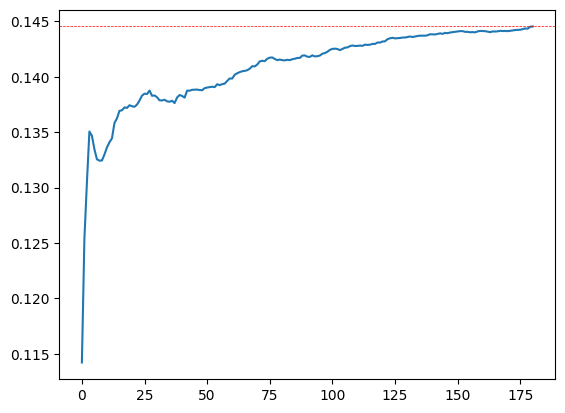

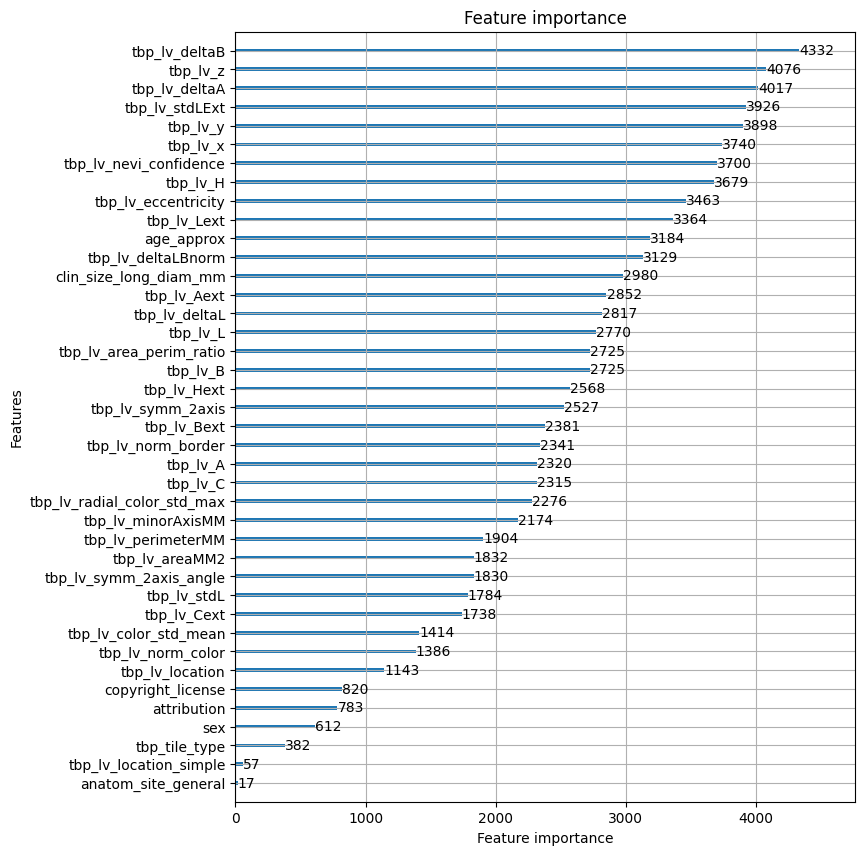

In [13]:

lgb_data = lgb.Dataset(X, label=y, categorical_feature=categorical_cols, free_raw_data=False)



__n_estimators         = random.choice([2000,2500,3000])                  # 800,900,1000,1100,1200,1300,
__learning_rate        = random.choice([0.002,0.001,0.0009])              # 0.005,0.004,
__lambda_l1            = random.choice([0.14,0.21,0.27,0.37])
__lambda_l2            = random.choice([0.7,1.0,1.47,1.77,2.77])
__pos_bagging_fraction = random.choice([0.74, 0.75, 0.77, 0.777])
__neg_bagging_fraction = random.choice([0.04,0.05,0.07,0.077])
__feature_fraction     = random.choice([0.5,0.54,0.57,0.7,0.77,0.777])
__num_leaves           = random.choice([16,30,33,37,40])                  # 24,30,31,32,33,37
__min_data_in_leaf     = random.choice([24,40,50,57,70])                  # 40,45,50,55,57

params_1 = {
    'objective': 'binary',
    "n_estimators":__n_estimators,
    'learning_rate':__learning_rate,
    'num_leaves':__num_leaves,
    'min_data_in_leaf':__min_data_in_leaf,
    'bagging_freq': 1,
    'pos_bagging_fraction':__pos_bagging_fraction,
    'neg_bagging_fraction':__neg_bagging_fraction,
    'feature_fraction':__feature_fraction,
    'lambda_l1':__lambda_l1,
    'lambda_l2':__lambda_l2,
    "verbosity": -1,
}

print('\n',
      __n_estimators,
      __learning_rate,
      __lambda_l1,
      __lambda_l2,
      __pos_bagging_fraction,
      __neg_bagging_fraction,
      __feature_fraction,
      __num_leaves,
      __min_data_in_leaf,
'\n')

# GroupKFold for cross-validation
group_kfold = sklearn.model_selection.GroupKFold(n_splits=5)

# Performing cross-validation with early stopping
cv_results_1 = lgb.cv(params_1,
                      lgb_data,
                      folds=group_kfold.split(X, y, groups),
                      feval=pauc_80,
                      num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=77), lgb.log_evaluation(10)],
                      stratified=False
                      )

# Best number of boosting rounds
best_num_boost_round_1 = len(cv_results_1['valid pauc_80-mean'])
print(f'Best number of boosting rounds: {best_num_boost_round_1}')
plt.plot(cv_results_1['valid pauc_80-mean'])
plt.axhline(max(cv_results_1['valid pauc_80-mean']), linewidth=0.5, color='red', linestyle='--');

# Train final model with the best number of boosting rounds
final_model_1 = lgb.train(params_1,
                          lgb_data,
                          num_boost_round = best_num_boost_round_1
                         )

lgb.plot_importance(final_model_1, figsize=(8, 10))

Create new features